# Predicting olympic athletes' performance

In [5]:
from sklearn.model_selection import train_test_split

from keras import models, layers, optimizers
from keras.utils.np_utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

### Preprocess the data

In [6]:
df = pd.read_csv(os.getcwd() + '/res/athlete_events.csv')

# ID & Name are irrelevant to performance
# Games is covered by Year and Season
# We won't cover Event or City for now
df = df.drop(columns=['ID', 'Name', 'Event', 'Games', 'City'])

### Map all string values to int

# Start by gathering all values present in dataset

sports = df['Sport'].unique().tolist()
teams = df['Team'].unique().tolist()
nocs = df['NOC'].unique().tolist()
medals = ['Bronze', 'Silver', 'Gold']

# Map values to ints

# Note we're assuming anyone without a specified medal didn't get one (by filling NaN with 0).
# However, this might not be the case - some NaNs could correspond to missing data
df['Medal'] = df['Medal'].map(lambda m: medals.index(m) + 1, na_action='ignore').fillna(0)

df['Sex'] = df['Sex'].map(lambda s: 0 if s == 'F' else 1)
df['Season'] = df['Season'].map(lambda s: 0 if s == 'Summer' else 1)
df['Sport'] = df['Sport'].map(lambda s: sports.index(s))
df['Team'] = df['Team'].map(lambda t: teams.index(t))
df['NOC'] = df['NOC'].map(lambda c: nocs.index(c))

### Normalise data

# Where values are already in the range [-1, 1] we will leave the columns unchanged
# Otherwise, we will shift and scale to mean 0 and std 1
# Columnds Height and Weight are missing values. We will return to these

mean_and_std = {}  # store mean and std for each column for use in preprocessing future data
for col in ('Age', 'Team', 'NOC', 'Year', 'Sport'):
    mean = df[col].mean()
    std = df[col].std()
    mean_and_std[col] = (mean, std)
    df[col] -= mean
    df[col] /= std

# Fill NaNs for Height and Weight with 0, a number well outside the typical ranges
for col in ('Height', 'Weight'):
    df[col] = df[col].fillna(0)

# Scale Height and Weight to be in the range [0, 1]
df['Height'] /= 200
df['Weight'] /= 100

# Show dataframe
display(df.head(10))

# Split target column Medal, and ...
# Convert dataframes to numpy arrays
# Convert target values to categorical
y = to_categorical(df['Medal'].values)
X = df.drop(columns=['Medal']).values

# Train test split. We shuffle to reduce chance of bias caused by initial ordering of rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101, shuffle=True)

,Sex,Age,Height,Weight,Team,NOC,Year,Season,Sport,Medal
0,1,-0.243510,0.900,0.80,-0.708269,-1.099228,0.455910,0,-1.436746,0.0
1,1,-0.399918,0.850,0.60,-0.708269,-1.099228,1.125307,0,-1.348747,0.0
2,1,-0.243510,0.000,0.00,-0.698777,-1.078900,-1.953919,0,-1.260748,0.0
3,1,1.320563,0.000,0.00,-0.689285,-1.078900,-2.623316,0,-1.172749,3.0
4,0,-0.712732,0.925,0.82,-0.679793,-1.058572,0.322031,1,-1.084749,0.0
5,0,-0.712732,0.925,0.82,-0.679793,-1.058572,0.322031,1,-1.084749,0.0
6,0,-0.087103,0.925,0.82,-0.679793,-1.058572,0.455910,1,-1.084749,0.0
7,0,-0.087103,0.925,0.82,-0.679793,-1.058572,0.455910,1,-1.084749,0.0
8,0,0.225712,0.925,0.82,-0.679793,-1.058572,0.522850,1,-1.084749,0.0
9,0,0.225712,0.925,0.82,-0.679793,-1.058572,0.522850,1,-1.084749,0.0


### Define network for single-label multiclass classification

In [69]:
model = models.Sequential()

hidden_layer_width = 8
model.add(layers.Dense(hidden_layer_width, activation='relu', input_dim=9))
model.add(layers.Dense(hidden_layer_width, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=10**-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.1, shuffle=True)

Train on 163482 samples, validate on 18165 samples
Epoch 1/10
163482/163482 [==============================] - 1s 9us/step - loss: 1.3156 - acc: 0.8529 - val_loss: 1.2420 - val_acc: 0.8525
Epoch 2/10
163482/163482 [==============================] - 1s 6us/step - loss: 1.1617 - acc: 0.8538 - val_loss: 1.0802 - val_acc: 0.8525
Epoch 3/10
163482/163482 [==============================] - 1s 6us/step - loss: 0.9962 - acc: 0.8538 - val_loss: 0.9152 - val_acc: 0.8525
Epoch 4/10
163482/163482 [==============================] - 1s 6us/step - loss: 0.8370 - acc: 0.8538 - val_loss: 0.7667 - val_acc: 0.8525
Epoch 5/10
163482/163482 [==============================] - 1s 6us/step - loss: 0.7048 - acc: 0.8538 - val_loss: 0.6549 - val_acc: 0.8525
Epoch 6/10
163482/163482 [==============================] - 1s 6us/step - loss: 0.6166 - acc: 0.8538 - val_loss: 0.5936 - val_acc: 0.8525
Epoch 7/10
163482/163482 [==============================] - 1s 6us/step - loss: 0.5808 - acc: 0.8538 - val_loss: 0.5808 -

### Plot training and validation loss

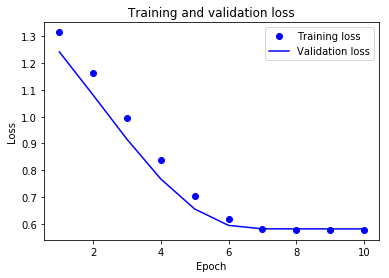

In [70]:
start_epoch = 0

loss = hist.history['loss'][start_epoch:]
val_loss = hist.history['val_loss'][start_epoch:]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluate model on test data

In [71]:
model.evaluate(X_test, y_test)

89469/89469 [==============================] - 1s 16us/step


[0.5807050369884535, 0.8524069789549364]